# Problem set 1 (100 pts)

## Important information

* Read [homework rules](../hw.pdf) carefully. <font color='red'>If you do not follow it you will likely be penalized.</font>


* We provide signatures of the functions for every coding task. Make sure you follow the signatures defined, otherwise your coding solutions will not be graded.

## Problem 0 (Piazza) Your solution will not be graded unless this problem is solved!

You were invited to Piazza, where you can find [announcement](https://piazza.com/class/j9cp73agv3u3w4?cid=7) on the course project. In case you didn't get an invitation to your @skoltech.ru email from Piazza, ask TA to set you up there. 
* Register in Piazza with your @skoltech.ru email.
* Write a private post to TAs in Piazza describing your favorite math fact (not necessarily a difficult one).

In [ ]:
#Done!

## Problem 1 (Python demo) 40 pts
### Data preparation (10 pts)

* First of all download $\verb|.wav|$ file with starcraft sound from [here](TMaRdy00.wav). Load it in python and play using the following functions:

In [1]:
from scipy.linalg import toeplitz
import numpy as np
import math
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
from IPython.display import Audio
%matplotlib notebook

<IPython.core.display.Javascript object>


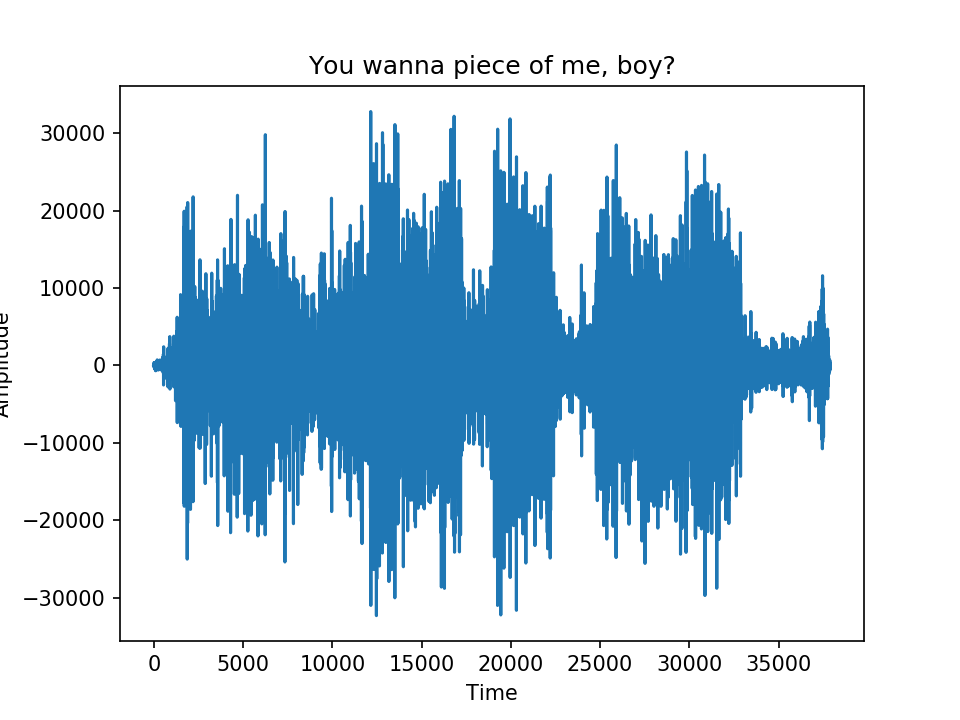

In [2]:
# reading
rate, audio = wav.read("TMaRdy00.wav")

# plotting
plt.plot(audio)
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.title("You wanna piece of me, boy?")
plt.show()

# playing
Audio(audio, rate=rate)

Our next goal is to process this signal by multiplying it by a special type of matrix (convolution operation) that will smooth the signal. 

* Before processing this file let us estimate what size of matrix we can afford. Let $N$ be the size of the signal. Estimate analytically memory in megabytes required to store dense square matrix of size $N\times N$ to fit in your operation memory and print this number. Cut the signal so that you will not have swap (overflow of the operation memory). **Note:** Cut the signal by taking every p-th number in array: ```signal[::p]```. 

In [5]:
signal = audio[::2]
N = len(signal)
print(N)

18944


* Write a function 
```python
def gen_toeplitz(N, alpha):    
    return T
```
that outputs matrix $T$: $$T_{ij} = \sqrt{\frac{\alpha}{\pi}}e^{-\alpha (i-j)^2}, \quad i,j=1,\dots,N$$ as numpy array. <font color='red'> Avoid using loops or lists! </font> The function [np.meshgrid](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.meshgrid.html) will be helpful for this task.
**Note:** matrices that depend only on difference of indices: $T_{ij} \equiv T_{i-j}$ are called **Toeplitz**. Toeplitz matrix-by-vector multiplication is **convolution** since it can be written as $$y_i = \sum_{j=1}^N T_{i-j} x_j.$$ Convolutions can be computed faster than $\mathcal{O}(N^2)$ complexity using Fast Fourier transform (will be covered later in our course, no need to implement it here).

In [11]:
# INPUT: N - integer (positive), alpha - float (positive)
# OUTPUT: T - np.array (shape: NxN)

def gen_toeplitz(N, alpha): # 5 pts
    
    # Write your code here
    xx, yy = np.meshgrid(np.arange(1,N+1),np.arange(1,N+1))
    T = np.sqrt(alpha/np.pi)*np.exp(-alpha*(xx-yy)**2)
    return T


### Convolution (10 pts)

* Write a function ```convolution``` (see below)
that takes the signal you want to convolve and multiply it by Toeplitz matrix $T$ (for matvec operations use @ symbol). Plot the first $100$ points of the result and the first $100$ points of your signal on the same figure. Do the same plots for $\alpha = \frac{1}{5}$, $\alpha = \frac{1}{100}$ using ```plt.subplots``` in matplotlib. Each subplot should contain first $100$ points of initial and convolved signals for some $\alpha$. Make sure that you got results that look like smoothed initial signal.

In [20]:
# INPUT: signal - np.array (shape: Nx1), N - int (positive), alpha - float (positive)
# OUTPUT: convolved_signal - np.array (shape: Nx1)

def convolution(signal, N, alpha): # 4 pts
    T = gen_toeplitz(N, alpha)
    # Write your code here   
    return T.dot(signal)


* Play the resulting signal. In order to do so you should also scale the frequency (rate), which is one of the inputs in `Audio`.  
Note that you cannot play a signal which is too small.

<IPython.core.display.Javascript object>


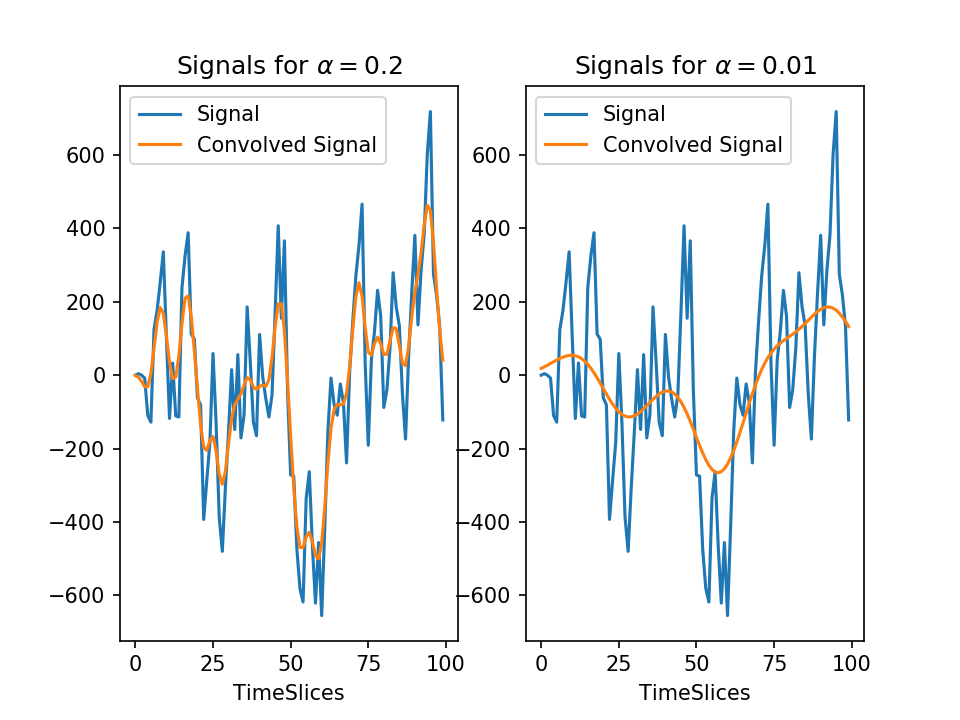

In [31]:
f, (ax1, ax2) = plt.subplots(1, 2)

signal1Plot, = ax1.plot(np.arange(100), signal[:100])
signal1ConvolvedPlot, = ax1.plot(np.arange(100), convolution(signal[:100],100,0.2))
ax1.set_title(r"Signals for $\alpha=0.2$")
ax1.set_xlabel("TimeSlices")
ax1.legend([signal1Plot, signal1ConvolvedPlot], ['Signal', 'Convolved Signal'])

ax2.plot(np.arange(100), signal[:100])
ax2.plot(np.arange(100), convolution(signal[:100],100,0.01))
ax2.set_xlabel("TimeSlices")
ax2.legend([signal1Plot, signal1ConvolvedPlot], ['Signal', 'Convolved Signal'])
ax2.set_title(r"Signals for $\alpha=0.01$")


### Deconvolution (20 pts)

Given a convolved signal $y$ and an initial signal $x$ our goal now is to recover $x$ by solving the system
$$
    y = Tx.
$$
To do so we will run iterative process
$$
    x_{k+1} = x_{k} - \tau_k (Tx_k - y), \quad k=1,2,\dots
$$
starting from zero vector $x_0$. There are different ways how to define parameters $\tau_k$.
Different choices lead to different methods (e.g. Richardson iteration, Chebyshev iteration, etc.).
This topic will be covered in details later in our course.

To get some intuition why this process converges to the solution of $Tx=y$, we can consider the following. Let us note that if $x_k$ converges to some limit $x$, then so does $x_{k+1}$. Taking $k\to \infty$ we arrive at $x = x - \tau (Tx -  y)$ and hence $x$ is the solution of $Tx = y$. 

Another important point is that iterative process requires only matrix-vector porducts $Tx_k$ on each iteration instead of the whole matrix. In this problem we, however, work with the full matrix, but keep in mind, that convolution can be done efficiently without storing the whole matrix.

* For each $k$ choose paremeter $\tau_k$ such that the residual $r_{k+1}=Tx_{k+1} - y$ is minimal possible (*line search* with search direction $r_k$):
$$
    \|Tx_{k+1} - y\|_2 \to \min_{\tau_k}
$$
found analytically. The answer to this bullet is a derivation of $\tau_k$. The parameter $\tau_k$ should be expressed in terms of residuals $r_k = T x_k - y$.

* Write a function ```iterative```
that outputs accuracy –– a numpy array of relative errors $\big\{\frac{\|x_{k+1} - x\|_2}{\|x\|_2}\big\}$ after ```num_iter``` iterations using $\tau_k$ from the previous task. Set ```num_iter=1000```, ```x=s[::20]``` and do a convergence plot for $\alpha = \frac{1}{2}$ and $\alpha = \frac{1}{5}$. **Note:** The only loop you are allowed to use here is a loop for $k$.

In [ ]:
# INPUT:  N - int (positive), alpha - float (positive), num_iter - integer (positive), y - np.array (shape: Nx1, convolved signal), s - np.array (shape: Nx1, original signal)
# OUTPUT: rel_error - np.array size (num_iter x 1)

def iterative(N, num_iter, y, s, alpha): # 10 pts
    # Write your code here
    return rel_error

* Set ```x=s[::20]```, ```num_iter=1000``` and $\alpha=\frac{1}{5}$. Explain what happens with the convergence if you add small random noise of amplitude $10^{-3}\max(x)$  to $y$. The answer to this question should be an explanation supported by plots and/or tables.

## Problem 2 (Theoretical tasks)  30 pts


_1._ (5 pts) Prove that $\|Ux\|_2 = \|x\|_2$ for any $x\in\mathbb{C}^n$ iff $U$ is unitary.
  
  
_2._ (5 pts) Prove that an operator norm is a matrix norm, i.e. it is a norm on the vector space of matrices and satisfies the submultiplicative property.


_3._ (5 pts) Prove that $\|A\|_2 = \sigma_1(A)$ and $\|A\|_F = \sqrt{\sigma_1^2(A) + \dots + \sigma_r^2(A)}$ using unitary invariance of $\|\cdot\|_2$ and $\|\cdot\|_F$.


_4._ (5 pts) Prove that $\|AB\|_F \leq \|A\|_2 \|B\|_F \leq \|A\|_F \|B\|_F$.


_5._ (5 pts) Find a gradient of the generalized Rayleigh quotient $R(x) = \dfrac{(x, Ax)}{(x, Bx)}$, $A=A^*$, $B>0$. How is zero gradient condition connected to the classical eigenvalue problem if $B=I$, where $I$ is the identity matrix.

_6._ (5 pts) Alternating optimization in the task of approximation of a matrix $A\in\mathbb{R}^{n\times m}$ with its rank-$r$ approximation $A_r \equiv UV^\top$, $U\in\mathbb{R}^{n\times r}$, $V\in\mathbb{R}^{m\times r}$ can be formulated as sequential minimization by $U$ and by $V$ of the functional $F(U,V)$: 

$$
    F(U,V) = \frac 12 \|A - UV^\top\|_F^2 + \frac{\lambda_U}2 \|U\|_F^2 + \frac{\lambda_V}2 \|V\|_F^2,
$$

where $\lambda_U,\lambda_V$ are regularization constants. 
Find gradient of $F(U,V)$ w.r.t. $U$ and $V$.

## Problem 3 (Strassen algorithm) 10 pts

1. What is the exact complexity of naive matrix-matrix multiplication? What is the complexity of Strassen algorithm? Can complexity of matrix-matrix multiplication be asymptotically smaller than $\mathcal{O}(n^2)$? Why?

2. It's a good idea not to do recursion to the bottom level in the Strassen algorithm. Let us check if only several   levels of the recursion help to reduce the constant outside $n^3$. Find analytically constant outside $n^3$ after $3$ levels of recursion in the Strassen algorithm. Compare it with the constant in the naive multiplication. **Note:** Assume that additions and multiplications in computer have the same computational cost.

## Problem 4 (SVD)  20 pts

In [3]:
# Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import scipy as sp
import scipy.ndimage

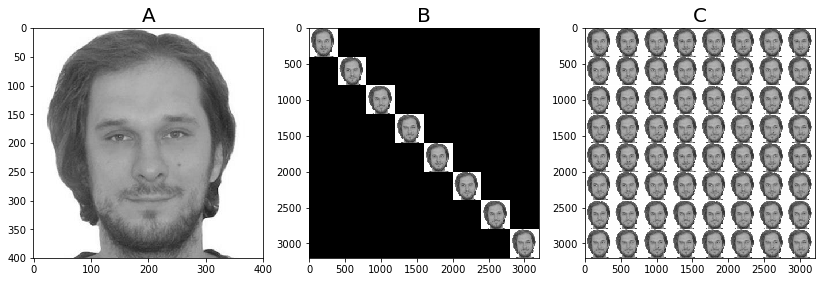

In [4]:
img = np.array(Image.open('ivan.png'), dtype=np.float64)
img_block = np.array(Image.open('ivan_block.png'), dtype=np.float64)
img_diag_block = np.array(Image.open('ivan_diag_block.png'), dtype=np.float64)
plt.figure(figsize=(14,6))
plt.subplot(131)
plt.title('A', fontsize=20)
plt.imshow(img, cmap=plt.cm.gray)
plt.subplot(132)
plt.title('B', fontsize=20)
plt.imshow(img_diag_block, cmap=plt.cm.gray)
plt.subplot(133)
plt.title('C', fontsize=20)
plt.imshow(img_block, cmap=plt.cm.gray)
plt.show()

### Part A (10 pts)

1. Obtain the singular values of Ivan image **A** using `np.linalg.svd` and plot them. Do not forget to use logarithmic scale.

2. Why is the exact rank of **A** is not equal to the size of the figure?

3. Create a function ```approximate``` that takes an image matrix $M$ and a relative accuracy $\epsilon$ as an input and returns an approximated image matrix $M_\epsilon$ such that $\|M - M_\epsilon\|_F / \|M\|_F \leq \epsilon$, and   rank$(M_\epsilon)$. See how the function ```approximate``` must look like below.

4. Plot $M_\epsilon$ (for image **A**). Estimate for which accuracy value $\epsilon$ image $M_\epsilon$ begins to "look like" $M$. Note that, eventually, pixel-wise proximity is not a good metric for image similarity when doing low-rank approximation.

5. Plot $M_\epsilon$ (for image **A**) such that $rank(M_\epsilon) = 5, 20, 50$ using ```plt.subplots```. Note that for even relatively small ranks  image is well-recognizable.

In [ ]:
def approximate(img, eps): # 5 pts out of 10 pts
    # your code here
    return img_appr, eps_rank

### Part B (10 pts)

1. Plot singular values for Ivan images **B** and **C** in one figure. Again, do not forget to use logarithmic scale! <br>

2. Derive analytically ranks of **B** and **C** from the rank of **A**.

## Problem 5 (Bonus)

1. The norm is called absolute if $\|x\|=\| \lvert x \lvert \|$ holds for any vector $x$, where $x=(x_1,\dots,x_n)^T$ and $\lvert x \lvert = (\lvert x_1 \lvert,\dots, \lvert x_n \lvert)^T$. Give an example of a norm which is not absolute.

2. Write a function ```ranks_HOSVD(A, eps)```
that calculates Tucker ranks of a d-dimensional tensor $A$ using High-Order SVD (HOSVD) algorithm, where ```eps``` is the relative accuracy in the Frobenius norm between the approximated and the initial tensors. Details can be found [here](http://ca.sandia.gov/~tgkolda/pubs/pubfiles/TensorReview.pdf) on Figure 4.3.
```python
def ranks_HOSVD(A, eps):
      return r #r should be a tuple of ranks r = (r1, r2, ..., rd)
```
3. Find Hessian of  $f(x_1,\dots,x_n) = \log \left( \displaystyle{\sum_{i=1}^n} e^{x_i} \right)$ and check if it is positive definite.